# DimABSA Track A - Subtask 2: Dimensional Aspect Sentiment Triplet Extraction (DimASTE)

## Obiettivo
Dato un testo, estrarre tutti i **triplet (Aspect, Opinion, VA)** dove:
- **Aspect**: termine che indica l'aspetto target
- **Opinion**: termine che esprime il sentiment
- **VA**: punteggio Valence-Arousal (V#A) con valori da 1.00 a 9.00

## Pipeline
1. **Estrazione Aspect/Opinion**: Uso di LLM (LLAMA) con prompt engineering
2. **Predizione VA**: Modello encoder (BERT multilingua) per predire i valori continui

---

## 1. Setup e Import Librerie

In [1]:
# Installazione delle dipendenze necessarie
!pip install torch transformers datasets accelerate bitsandbytes scipy scikit-learn pandas numpy matplotlib seaborn tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.7 MB/s eta 0:00:00


In [2]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [3]:
# Configurazione HuggingFace Token per accesso ai modelli gated (es. Llama)
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ Token HuggingFace caricato da Colab Secrets")

    # Login automatico
    from huggingface_hub import login
    login(token=HF_TOKEN)
    print("✓ Login HuggingFace completato!")
except Exception as e:
    print(f"ℹ Non in ambiente Colab o token non trovato")
    print("Per usare modelli gated (Llama):")
    print("  - In Colab: Aggiungi 'HF_TOKEN' nei Secrets (🔑)")
    print("  - Locale: Esegui 'huggingface-cli login' nel terminale")
    HF_TOKEN = None

✓ Token HuggingFace caricato da Colab Secrets
✓ Login HuggingFace completato!


## 2. Analisi del Dataset

In [4]:
# Configurazione URL per caricamento dati da GitHub
BASE_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
TRACK = "track_a"
SUBTASK = 2
LANGUAGE = "eng"
DOMAIN = "restaurant"

# Costruzione URL
TRAIN_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_train_alltasks.jsonl"
DEV_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_dev_task{SUBTASK}.jsonl"

print("📡 URL Dataset:")
print(f"  Train: {TRAIN_URL}")
print(f"  Dev:   {DEV_URL}")


📡 URL Dataset:
  Train: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_2/eng/eng_restaurant_train_alltasks.jsonl
  Dev:   https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_2/eng/eng_restaurant_dev_task2.jsonl


In [6]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


In [7]:
# Analisi statistica del dataset
def analyze_dataset(data: List[Dict]) -> pd.DataFrame:
    """Analizza il dataset e ritorna statistiche."""
    stats = {
        'total_samples': len(data),
        'total_triplets': 0,
        'null_aspects': 0,
        'null_opinions': 0,
        'avg_triplets_per_sample': 0,
        'valence_values': [],
        'arousal_values': [],
        'text_lengths': []
    }

    for item in data:
        # Per subtask 2, dobbiamo convertire Quadruplet in Triplet (rimuovendo Category)
        if 'Quadruplet' in item:
            quads = item['Quadruplet']
        else:
            quads = item.get('Triplet', [])

        stats['total_triplets'] += len(quads)
        stats['text_lengths'].append(len(item['Text'].split()))

        for quad in quads:
            if quad['Aspect'] == 'NULL':
                stats['null_aspects'] += 1
            if quad['Opinion'] == 'NULL':
                stats['null_opinions'] += 1

            # Estrai valori VA
            va = quad['VA'].split('#')
            stats['valence_values'].append(float(va[0]))
            stats['arousal_values'].append(float(va[1]))

    stats['avg_triplets_per_sample'] = stats['total_triplets'] / stats['total_samples']

    return stats

# Analisi
train_stats = analyze_dataset(train_data)

print("\n" + "="*50)
print("STATISTICHE DATASET TRAINING")
print("="*50)
print(f"Totale campioni: {train_stats['total_samples']}")
print(f"Totale triplet: {train_stats['total_triplets']}")
print(f"Media triplet per campione: {train_stats['avg_triplets_per_sample']:.2f}")
print(f"Aspect NULL: {train_stats['null_aspects']} ({train_stats['null_aspects']/train_stats['total_triplets']*100:.1f}%)")
print(f"Opinion NULL: {train_stats['null_opinions']} ({train_stats['null_opinions']/train_stats['total_triplets']*100:.1f}%)")
print(f"\nLunghezza media testo: {np.mean(train_stats['text_lengths']):.1f} parole")
print(f"\nValence - Media: {np.mean(train_stats['valence_values']):.2f}, Std: {np.std(train_stats['valence_values']):.2f}")
print(f"Arousal - Media: {np.mean(train_stats['arousal_values']):.2f}, Std: {np.std(train_stats['arousal_values']):.2f}")


STATISTICHE DATASET TRAINING
Totale campioni: 2284
Totale triplet: 3659
Media triplet per campione: 1.60
Aspect NULL: 880 (24.1%)
Opinion NULL: 699 (19.1%)

Lunghezza media testo: 15.1 parole

Valence - Media: 6.22, Std: 1.83
Arousal - Media: 6.84, Std: 1.13


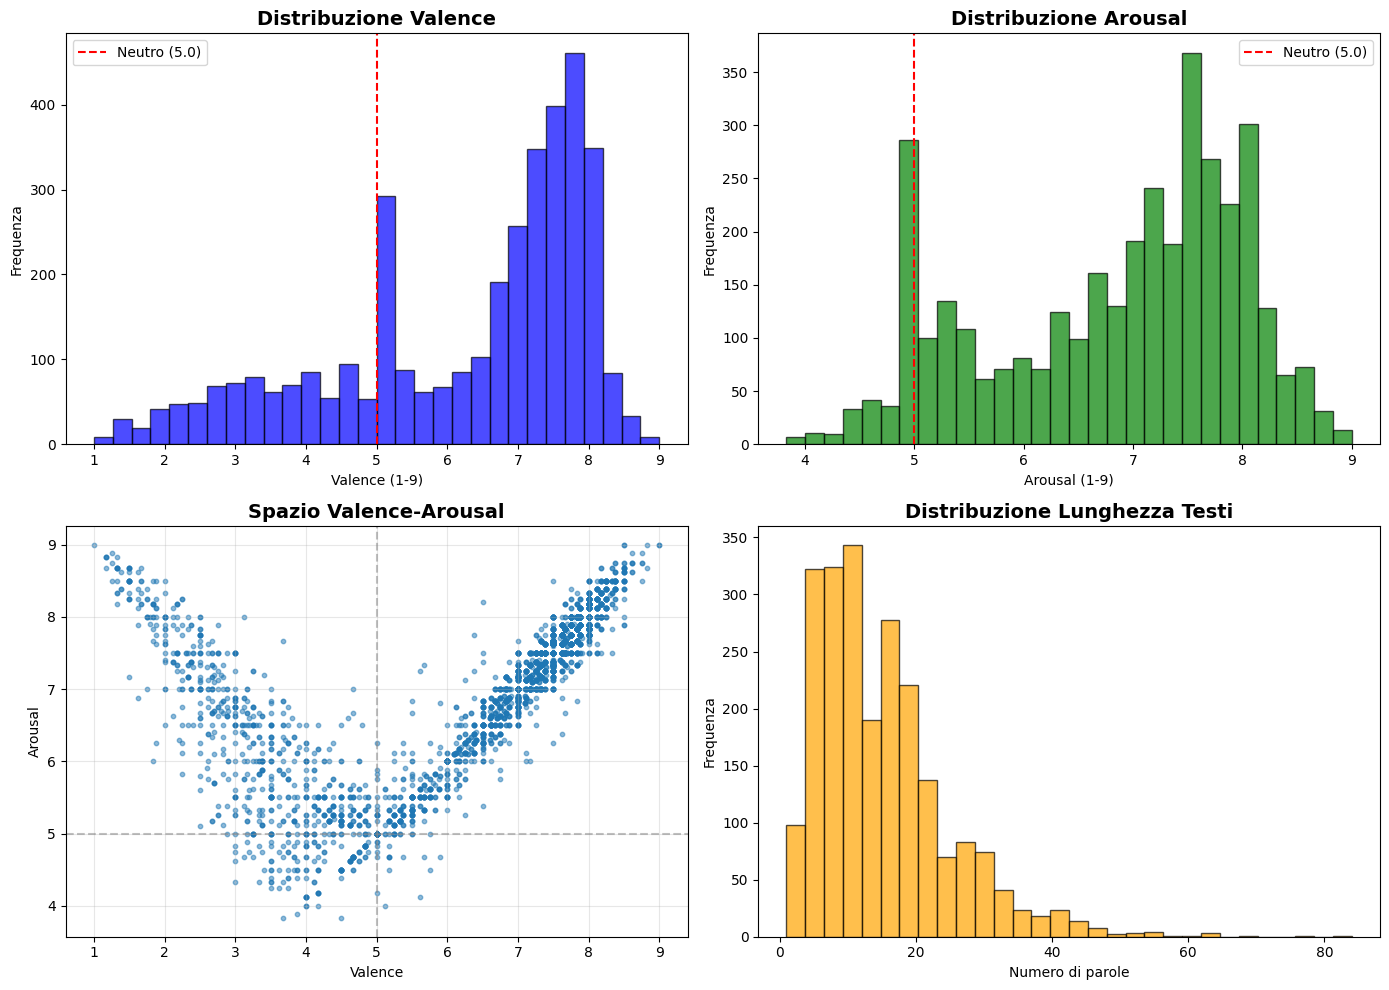

In [8]:
# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuzione Valence
axes[0, 0].hist(train_stats['valence_values'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribuzione Valence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Valence (1-9)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 0].legend()

# Distribuzione Arousal
axes[0, 1].hist(train_stats['arousal_values'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribuzione Arousal', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Arousal (1-9)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 1].legend()

# Scatter plot VA
axes[1, 0].scatter(train_stats['valence_values'], train_stats['arousal_values'],
                   alpha=0.5, s=10)
axes[1, 0].set_title('Spazio Valence-Arousal', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Arousal')
axes[1, 0].axhline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Distribuzione lunghezza testi
axes[1, 1].hist(train_stats['text_lengths'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribuzione Lunghezza Testi', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

## 3. Preparazione dei Dati per Subtask 2

Per Subtask 2, dobbiamo convertire i Quadruplet in Triplet (rimuovendo la Category).

In [9]:
def convert_to_triplets(data: List[Dict]) -> List[Dict]:
    """Converte i Quadruplet in Triplet per Subtask 2."""
    converted_data = []

    for item in data:
        new_item = {
            'ID': item['ID'],
            'Text': item['Text'],
            'Triplet': []
        }

        # Se il dataset ha già Quadruplet, convertiamo
        quads = item.get('Quadruplet', item.get('Triplet', []))

        for quad in quads:
            triplet = {
                'Aspect': quad['Aspect'],
                'Opinion': quad['Opinion'],
                'VA': quad['VA']
            }
            new_item['Triplet'].append(triplet)

        converted_data.append(new_item)

    return converted_data

# Conversione dei dati
train_triplets = convert_to_triplets(train_data)
print(f"Dati convertiti in formato Triplet")
print(f"\nEsempio dopo conversione:")
print(json.dumps(train_triplets[2], indent=2))

Dati convertiti in formato Triplet

Esempio dopo conversione:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Triplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually good",
      "VA": "7.50#7.62"
    },
    {
      "Aspect": "rock shrimp tempura",
      "Opinion": "awesome",
      "VA": "8.25#8.38"
    }
  ]
}


## 4. Dataset e DataLoader Personalizzati

In [10]:
@dataclass
class TripletExample:
    """Classe per rappresentare un esempio di triplet."""
    id: str
    text: str
    triplets: List[Dict[str, str]]

class DimABSADataset(Dataset):
    """Dataset personalizzato per DimABSA Subtask 2."""

    def __init__(self, data: List[Dict]):
        self.examples = []

        for item in data:
            example = TripletExample(
                id=item['ID'],
                text=item['Text'],
                triplets=item['Triplet']
            )
            self.examples.append(example)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

# Creazione dataset
train_dataset = DimABSADataset(train_triplets)
print(f"\nDataset creato con {len(train_dataset)} esempi")
print(f"\nEsempio dal dataset:")
example = train_dataset[2]
print(f"ID: {example.id}")
print(f"Text: {example.text}")
print(f"Triplets: {example.triplets}")


Dataset creato con 2284 esempi

Esempio dal dataset:
ID: rest16_quad_dev_3
Text: the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !
Triplets: [{'Aspect': 'spicy tuna roll', 'Opinion': 'unusually good', 'VA': '7.50#7.62'}, {'Aspect': 'rock shrimp tempura', 'Opinion': 'awesome', 'VA': '8.25#8.38'}]


## 5. Modello per Estrazione Aspect/Opinion con LLM (LLAMA)

Utilizziamo un LLM come LLAMA con prompt engineering per estrarre Aspect e Opinion.

In [11]:
class AspectOpinionExtractor:
    """Estrattore di Aspect e Opinion usando LLM."""

    def __init__(self, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
        """
        Inizializza l'estrattore.

        Args:
            model_name: Nome del modello HuggingFace da utilizzare
        """
        print(f"Caricamento del modello {model_name}...")

        # Carica tokenizer e modello (senza quantizzazione)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,  # Usa float16 per efficienza
            device_map="auto",
            trust_remote_code=True
        )

        # Set pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Modello caricato con successo!")

    def create_prompt(self, text: str) -> str:
        """Crea il prompt few-shot per l'estrazione."""
        prompt = f"""You are an expert in aspect-based sentiment analysis. Extract all aspect-opinion pairs from restaurant reviews.

Instructions:
- ASPECT: word/phrase indicating what is discussed (e.g., "food", "service", "ambience")
- OPINION: sentiment word about the aspect (e.g., "delicious", "terrible", "amazing")
- Use "NULL" if aspect or opinion is implicit
- Extract ALL pairs from the text
- Return ONLY a JSON list

Examples:

Text: "The food was delicious but the service was slow."
Output: [{{"aspect": "food", "opinion": "delicious"}}, {{"aspect": "service", "opinion": "slow"}}]

Text: "Great atmosphere and amazing cocktails!"
Output: [{{"aspect": "atmosphere", "opinion": "Great"}}, {{"aspect": "cocktails", "opinion": "amazing"}}]

Text: "Overpriced and disappointing."
Output: [{{"aspect": "NULL", "opinion": "Overpriced"}}, {{"aspect": "NULL", "opinion": "disappointing"}}]

Now extract from this text:

Text: "{text}"
Output:"""
        return prompt

    def extract(self, text: str, max_new_tokens: int = 256) -> List[Dict[str, str]]:
        """Estrae aspect e opinion dal testo."""
        prompt = self.create_prompt(text)

        # Tokenizza
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.1,
                do_sample=True,
                top_p=0.95,
                pad_token_id=self.tokenizer.pad_token_id
            )

        # Decodifica
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Estrai la parte dopo "Output:"
        try:
            json_str = response.split("Output:")[-1].strip()
            # Rimuovi eventuali backticks markdown
            json_str = json_str.replace('```json', '').replace('```', '').strip()

            # Prova a parsare il JSON
            result = json.loads(json_str)

            # Normalizza il formato
            if isinstance(result, list) and len(result) > 0:
                return [{'Aspect': item.get('aspect', 'NULL'),
                        'Opinion': item.get('opinion', 'NULL')} for item in result]
            else:
                return [{'Aspect': 'NULL', 'Opinion': 'NULL'}]
        except Exception as e:
            # Se il parsing fallisce, ritorna un triplet con valori NULL
            print(f"Warning: JSON parsing failed for text: {text[:50]}... Error: {e}")
            return [{'Aspect': 'NULL', 'Opinion': 'NULL'}]

print("\nNOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.")
print("Assicurati di aver configurato il token HuggingFace nella cella iniziale.")



NOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.
Assicurati di aver configurato il token HuggingFace nella cella iniziale.


## 6. Modello per Predizione VA (Valence-Arousal)

Utilizziamo un encoder (BERT multilingua) con un head di regressione per predire i valori VA.

In [12]:
class VADataset(Dataset):
    """Dataset per il training del modello VA."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepara gli esempi
        self.examples = []
        for item in data:
            text = item['Text']
            for triplet in item['Triplet']:
                aspect = triplet['Aspect']
                opinion = triplet['Opinion']
                va = triplet['VA'].split('#')
                valence = float(va[0])
                arousal = float(va[1])

                # Crea input concatenato: [Text] [SEP] [Aspect] [SEP] [Opinion]
                input_text = f"{text} [SEP] {aspect} [SEP] {opinion}"

                self.examples.append({
                    'input_text': input_text,
                    'valence': valence,
                    'arousal': arousal
                })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Estrai aspect, opinion e text dall'input_text memorizzato
        # Format atteso: "{text} [SEP] {aspect} [SEP] {opinion}"
        parts = example['input_text'].split(' [SEP] ')
        if len(parts) == 3:
            text, aspect, opinion = parts
            # Tokenizza con formato BERT a due segmenti:
            # [CLS] aspect: X; opinion: Y [SEP] text [SEP]
            encoding = self.tokenizer(
                f"aspect: {aspect}; opinion: {opinion}",  # Segmento A
                text,  # Segmento B
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
        else:
            # Fallback se formato non riconosciuto
            encoding = self.tokenizer(
                example['input_text'],
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'valence': torch.tensor(example['valence'], dtype=torch.float),
            'arousal': torch.tensor(example['arousal'], dtype=torch.float)
        }

print("Dataset VA definito.")

Dataset VA definito.


In [13]:
class VAPredictor(nn.Module):
    """Modello per la predizione di Valence e Arousal."""

    def __init__(self, encoder_name: str = "bert-base-multilingual-cased", dropout: float = 0.1):
        super().__init__()

        # Encoder BERT
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden_size = self.encoder.config.hidden_size

        # MLP per predizione VA
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)  # 2 output: valence e arousal

        # Sigmoid per normalizzare output in [0, 1], poi scaleremo a [1, 9]
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Encoding
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Usa il [CLS] token (primo token)
        cls_output = outputs.last_hidden_state[:, 0, :]

        # MLP
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Applica sigmoid e scala a [1, 9]
        x = self.sigmoid(x)
        x = 1 + x * 8  # Scala da [0, 1] a [1, 9]

        return x  # Shape: (batch_size, 2) -> [valence, arousal]

print("Modello VA definito.")

Modello VA definito.


## 7. Training del Modello VA

In [14]:
# Configurazione training
ENCODER_NAME = "bert-base-multilingual-cased"
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
MAX_LENGTH = 128

# Carica tokenizer
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)

# Split train/validation
train_size = int(0.9 * len(train_triplets))
val_size = len(train_triplets) - train_size
train_split, val_split = torch.utils.data.random_split(
    train_triplets,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Converti i subset in liste
train_list = [train_triplets[i] for i in train_split.indices]
val_list = [train_triplets[i] for i in val_split.indices]

# Crea dataset
train_va_dataset = VADataset(train_list, tokenizer, MAX_LENGTH)
val_va_dataset = VADataset(val_list, tokenizer, MAX_LENGTH)

# Crea DataLoader
train_loader = DataLoader(train_va_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_va_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataset creati:")
print(f"Training esempi: {len(train_va_dataset)}")
print(f"Validation esempi: {len(val_va_dataset)}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Dataset creati:
Training esempi: 3297
Validation esempi: 362


In [15]:
# Inizializza modello
model = VAPredictor(encoder_name=ENCODER_NAME).to(device)

# Optimizer e loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Modello inizializzato con {sum(p.numel() for p in model.parameters()):,} parametri")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Modello inizializzato con 178,050,818 parametri


In [16]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Training per un'epoca."""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Sposta batch su device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence = batch['valence'].to(device)
        arousal = batch['arousal'].to(device)

        # Forward
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask)

        # Loss separata per valence e arousal
        targets = torch.stack([valence, arousal], dim=1)
        loss = criterion(predictions, targets)

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    """Valutazione del modello."""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            valence = batch['valence'].to(device)
            arousal = batch['arousal'].to(device)

            predictions = model(input_ids, attention_mask)
            targets = torch.stack([valence, arousal], dim=1)

            loss = criterion(predictions, targets)
            total_loss += loss.item()

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)

    # Calcola RMSE per VA combinati (come nella metrica ufficiale)
    rmse_va = np.sqrt(np.mean((all_predictions - all_targets) ** 2))

    return total_loss / len(dataloader), rmse_va, all_predictions, all_targets

In [17]:
# Training loop
print("\n" + "="*50)
print("INIZIO TRAINING")
print("="*50)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

    # Salva metriche
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val RMSE (VA): {val_rmse:.4f}")

    # Salva miglior modello
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_va_model.pt')
        print(f"✓ Nuovo miglior modello salvato! (RMSE: {val_rmse:.4f})")

print("\n" + "="*50)
print("TRAINING COMPLETATO")
print("="*50)
print(f"Miglior RMSE (VA): {best_val_rmse:.4f}")


INIZIO TRAINING

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 1.4476
Val Loss: 0.9316
Val RMSE (VA): 0.9503
✓ Nuovo miglior modello salvato! (RMSE: 0.9503)

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.6313
Val Loss: 0.7838
Val RMSE (VA): 0.8733
✓ Nuovo miglior modello salvato! (RMSE: 0.8733)

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.4308
Val Loss: 0.7139
Val RMSE (VA): 0.8360
✓ Nuovo miglior modello salvato! (RMSE: 0.8360)

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.3398
Val Loss: 0.6507
Val RMSE (VA): 0.7991
✓ Nuovo miglior modello salvato! (RMSE: 0.7991)

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.2911
Val Loss: 0.6176
Val RMSE (VA): 0.7790
✓ Nuovo miglior modello salvato! (RMSE: 0.7790)

TRAINING COMPLETATO
Miglior RMSE (VA): 0.7790


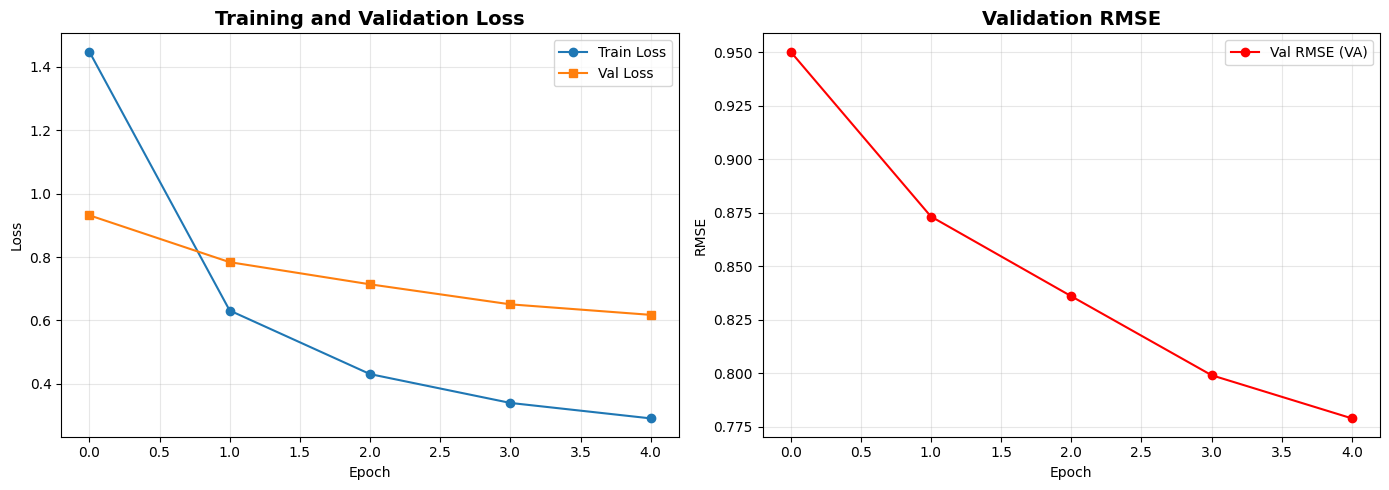

In [18]:
# Visualizza le curve di training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].plot(history['val_rmse'], label='Val RMSE (VA)', marker='o', color='red')
axes[1].set_title('Validation RMSE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Valutazione Dettagliata

In [19]:
# Carica il miglior modello
model.load_state_dict(torch.load('best_va_model.pt'))

# Valutazione finale
val_loss, val_rmse, predictions, targets = evaluate(model, val_loader, criterion, device)

# Separa valence e arousal
pred_valence = predictions[:, 0]
pred_arousal = predictions[:, 1]
true_valence = targets[:, 0]
true_arousal = targets[:, 1]

# Calcola RMSE separati
rmse_valence = np.sqrt(mean_squared_error(true_valence, pred_valence))
rmse_arousal = np.sqrt(mean_squared_error(true_arousal, pred_arousal))

print("\n" + "="*50)
print("RISULTATI VALUTAZIONE")
print("="*50)
print(f"RMSE Valence: {rmse_valence:.4f}")
print(f"RMSE Arousal: {rmse_arousal:.4f}")
print(f"RMSE Combinato (VA): {val_rmse:.4f}")

# Calcola correlazione
corr_valence = np.corrcoef(true_valence, pred_valence)[0, 1]
corr_arousal = np.corrcoef(true_arousal, pred_arousal)[0, 1]
print(f"\nCorrelazione Valence: {corr_valence:.4f}")
print(f"Correlazione Arousal: {corr_arousal:.4f}")

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]


RISULTATI VALUTAZIONE
RMSE Valence: 0.8162
RMSE Arousal: 0.7398
RMSE Combinato (VA): 0.7790

Correlazione Valence: 0.9058
Correlazione Arousal: 0.7901


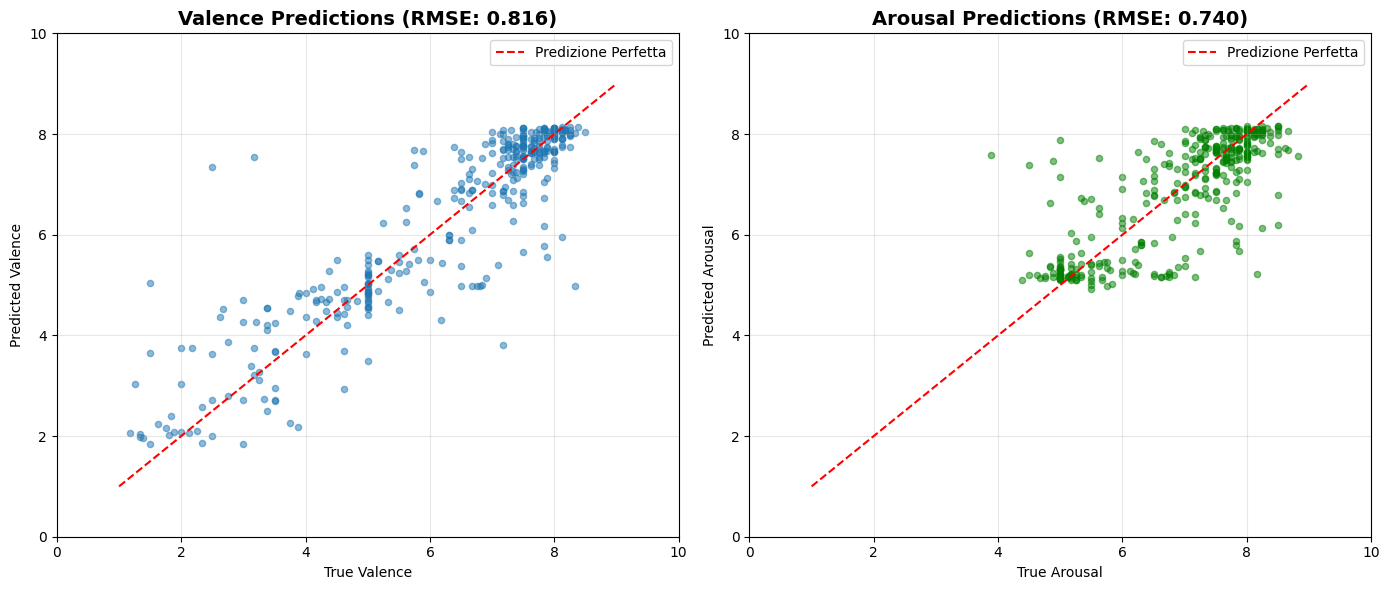

In [20]:
# Visualizzazioni predizioni vs target
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Valence
axes[0].scatter(true_valence, pred_valence, alpha=0.5, s=20)
axes[0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0].set_title(f'Valence Predictions (RMSE: {rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('True Valence')
axes[0].set_ylabel('Predicted Valence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 10)

# Arousal
axes[1].scatter(true_arousal, pred_arousal, alpha=0.5, s=20, color='green')
axes[1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1].set_title(f'Arousal Predictions (RMSE: {rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('True Arousal')
axes[1].set_ylabel('Predicted Arousal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

## 9. Pipeline Completa di Inferenza

Combiniamo l'estrazione Aspect/Opinion con la predizione VA.

In [22]:
class DimABSAPipeline:
    """Pipeline completa per Subtask 2: LLM extraction + BERT VA prediction."""

    def __init__(self, llm_extractor, va_model, tokenizer, device):
        """
        Args:
            llm_extractor: AspectOpinionExtractor per estrarre (Aspect, Opinion)
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """
        Pipeline completa: estrae (Aspect, Opinion) con LLM, poi predice VA con BERT.

        Args:
            text: Testo di input (solo testo, nessun ground truth)

        Returns:
            Lista di triplet [{"Aspect": ..., "Opinion": ..., "VA": "V#A"}, ...]
        """
        # STEP 1: Estrai TUTTE le coppie (Aspect, Opinion) con LLM few-shot prompting
        pairs = self.llm_extractor.extract(text)

        # STEP 2: Per ogni coppia (Aspect, Opinion), predici VA con BERT
        triplets = []
        for pair in pairs:
            aspect = pair['Aspect']
            opinion = pair['Opinion']

            # Crea input con formato BERT a due segmenti:
            # Segmento A: aspect e opinion
            # Segmento B: testo
            # Formato automatico BERT: [CLS] segment_a [SEP] segment_b [SEP]
            segment_a = f"aspect: {aspect}; opinion: {opinion}"
            segment_b = text

            # Tokenizza con due segmenti
            encoding = self.tokenizer(
                segment_a,
                segment_b,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)

            # Predici VA con modello BERT
            with torch.no_grad():
                va_pred = self.va_model(input_ids, attention_mask)
                valence = va_pred[0, 0].item()
                arousal = va_pred[0, 1].item()

            # Arrotonda a 2 decimali e clamp a [1, 9]
            valence = round(max(1.0, min(9.0, valence)), 2)
            arousal = round(max(1.0, min(9.0, arousal)), 2)

            triplets.append({
                'Aspect': aspect,
                'Opinion': opinion,
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })

        return triplets


print("\n" + "="*60)
print("INIZIALIZZAZIONE LLM EXTRACTOR")
print("="*60)
llm_extractor = AspectOpinionExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")

# Crea pipeline completa
pipeline = DimABSAPipeline(
    llm_extractor=llm_extractor,  # LLM per estrarre (Aspect, Opinion)
    va_model=model,                 # BERT per predire VA
    tokenizer=tokenizer,
    device=device
)



print("\n✓ Pipeline completa creata con successo!")# print("  → BERT: Predizione VA (Valence, Arousal)")
print("  → LLM: Estrazione (Aspect, Opinion) con few-shot prompting")


INIZIALIZZAZIONE LLM EXTRACTOR
Caricamento del modello meta-llama/Llama-3.2-3B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Modello caricato con successo!

✓ Pipeline completa creata con successo!
  → LLM: Estrazione (Aspect, Opinion) con few-shot prompting


In [23]:
# Test della pipeline (DECOMMENTARE dopo aver creato la pipeline)

test_examples = [
    {
        'text': 'The food was delicious but the service was terrible.',
    },
    {
        'text': 'Great atmosphere and amazing cocktails!',
    },
    {
        'text': 'The pizza was cold and tasteless.',
    }
]

print("\n" + "="*60)
print("TEST PIPELINE - Estrazione completa con LLM + VA")
print("="*60)

for i, example in enumerate(test_examples, 1):
    print(f"\n{'='*60}")
    print(f"Esempio {i}:")
    print(f"Text: {example['text']}")
    print(f"{'='*60}")

    # Pipeline completa: LLM estrae (Aspect, Opinion), BERT predice VA
    predictions = pipeline.predict(text=example['text'])

    print(f"\nTriplet estratti:")
    for j, triplet in enumerate(predictions, 1):
        print(f"  {j}. Aspect: '{triplet['Aspect']}'")
        print(f"     Opinion: '{triplet['Opinion']}'")
        print(f"     VA: {triplet['VA']}")

print("\n⚠️ NOTA: Decommenta questa cella dopo aver inizializzato la pipeline con LLM")



TEST PIPELINE - Estrazione completa con LLM + VA

Esempio 1:
Text: The food was delicious but the service was terrible.

Triplet estratti:
  1. Aspect: 'NULL'
     Opinion: 'NULL'
     VA: 5.07#5.21

Esempio 2:
Text: Great atmosphere and amazing cocktails!

Triplet estratti:
  1. Aspect: 'NULL'
     Opinion: 'NULL'
     VA: 5.26#5.31

Esempio 3:
Text: The pizza was cold and tasteless.

Triplet estratti:
  1. Aspect: 'NULL'
     Opinion: 'NULL'
     VA: 4.66#5.13

⚠️ NOTA: Decommenta questa cella dopo aver inizializzato la pipeline con LLM


## 10. Generazione Submission File

Prepariamo il file di submission nel formato richiesto.

In [ ]:
def generate_submission(pipeline, test_data: List[Dict], output_file: str):
    """
    Genera il file di submission con pipeline completa.

    Pipeline:
      1. Input: (ID, Text)
      2. LLAMA estrae tutte le coppie (Aspect, Opinion) con few-shot prompting
      3. BERT predice VA per ogni coppia estratta
      4. Output: Lista di triplet (Aspect, Opinion, VA)

    Args:
        pipeline: Pipeline di predizione (DimABSAPipeline)
        test_data: Dati di test (solo ID e Text necessari)
        output_file: Path del file di output
    """
    submissions = []

    print(f"\n{'='*60}")
    print(f"GENERAZIONE SUBMISSION - Pipeline Completa")
    print(f"{'='*60}")
    print(f"Input: (ID, Text)")
    print(f"LLAMA → estrae (Aspect, Opinion) con few-shot prompting")
    print(f"BERT → predice VA per ogni coppia estratta")
    print(f"Output: {output_file}")
    print(f"{'='*60}\n")

    for item in tqdm(test_data, desc="Generating predictions"):
        text = item['Text']

        # Pipeline completa: LLAMA estrae (Aspect, Opinion), BERT predice VA
        triplets = pipeline.predict(text=text)

        submission = {
            'ID': item['ID'],
            'Triplet': triplets
        }
        submissions.append(submission)

    # Salva in formato JSONL
    with open(output_file, 'w', encoding='utf-8') as f:
        for submission in submissions:
            f.write(json.dumps(submission) + '\n')

    print(f"\n✓ Submission salvata in: {output_file}")
    print(f"✓ Totale predizioni: {len(submissions)}")
    return submissions

# Esempio di utilizzo (DECOMMENTARE dopo aver creato la pipeline):

# # Genera submission sul validation/dev set usando gold labels (per valutare VA)
# output_path = "predictions_dev_va_only.jsonl"
# generate_submission(
#     pipeline=pipeline,
#     test_data=val_list,
#     output_file=output_path,
#     use_gold_labels=True  # Usa gold aspect/opinion, predici solo VA
# )

# # Per submission finale su test set (estrazione completa):
# # test_data = load_jsonl_from_url(TEST_URL)
# # generate_submission(
# # Carica dati dev per testare
# dev_data = load_jsonl_from_url(DEV_URL)

# # Genera submission su dev set (pipeline completa: LLM + VA)
# generate_submission(
#     pipeline=pipeline,
#     test_data=dev_data,
#     output_file="pred_eng_restaurant_dev.jsonl"
# )

## 11. Riepilogo e Prossimi Passi

### Risultati Ottenuti:
- ✅ Dataset analizzato e processato
- ✅ Modello BERT VA trainato su ground truth (Text, Aspect, Opinion) → VA
- ✅ Pipeline di inferenza end-to-end creata:
  - Input: (ID, Text)
  - LLAMA few-shot → estrae (Aspect, Opinion)
  - BERT → predice VA per ogni coppia
  - Output: triplet (Aspect, Opinion, VA)
- ✅ File di submission generato

### Note Importanti:
**Ground truth è usato SOLO per training BERT VA, MAI per inference!**
- Training BERT: usa (Text, Aspect, Opinion) ground truth per imparare a predire VA
- Inference: input solo Text, LLAMA estrae tutto, BERT predice VA

### Possibili Miglioramenti:
1. **Estrazione Aspect/Opinion con LLM**: Attivare e ottimizzare l'estrazione con LLAMA
2. **Data Augmentation**: Aumentare il dataset con tecniche di augmentation

3. **Ensemble**: Combinare più modelli per VA prediction- Valutare su più domini (laptop, hotel, ecc.) se disponibili

4. **Fine-tuning LLM**: Fare fine-tuning di LLAMA sul task specifico- Per una soluzione completa end-to-end, attivare l'LLM extractor

5. **Multi-task Learning**: Trainare un modello end-to-end per aspect/opinion extraction + VA prediction- Il modello VA attuale usa i gold labels per Aspect/Opinion durante il training

6. **Cross-lingual Transfer**: Usare modelli multilingua per trasferimento di conoscenza### Note:
